##  Notebook 3 of 5
# Machine Learning Based Unbalance Detection of a Rotating Shaft Using Vibration Data
### Oliver Mey, Willi Neudeck, André Schneider and Olaf Enge-Rosenblatt
##### Fraunhofer IIS/EAS, Fraunhofer Institute for Integrated Circuits, Division Engineering of Adaptive Systems, Dresden, Germany

This Jupyter Notebook is part of a paper submission to the 25th IEEE International Conference on Emerging Technologies and Factory Automation, ETFA 2020. The notebook is the first one in a series of five freely available notebooks. It contains Python code fragments which were used to get the classifications results described within the ETFA paper. 

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
import zipfile
from sklearn.preprocessing import RobustScaler

## Reading Measurement Data

The entire dataset is freely available via the Fraunhofer Fortadis data space (https://fordatis.fraunhofer.de/handle/fordatis/151.2). Anyone who is interested can checkout this data set and can carry out all the calculations described in the publication for themselves. Since the size of the entire dataset is about 2.7 GB, this notebook offers two options: a) A small subset can be used for a first trial. The ZIP file is part of this Github repository. b) The entire dataset is available via the URL as described below. In total, datasets for 4 different unbalance strengths were recorded (1D/1E ... 4D/4E) as well as one dataset with the unbalance holder without additional weight (i.e. without unbalance, 0D/0E). Each dataset is provided as a csv-file with five columns.



In [2]:
# Option a) local file contains a small subset of the entire dataset
url = '../data/fraunhofer_eas_dataset_for_unbalance_detection_v1.zip'

# Option b) the entire dataset can be directly downloaded via public Fraunhofer Fortadis dataspace
#url = 'https://fordatis.fraunhofer.de/bitstream/fordatis/151.2/1/fraunhofer_eas_dataset_for_unbalance_detection_v1.zip'

# Option c) selected pre-trained models can be found in the directory model/reference
use_reference_models = True
model_path = '../models/reference'

# Option d) all models will be trained again
#use_reference_models = False
#model_path = '../models'

In [3]:
with zipfile.ZipFile(url, 'r') as f:
    with f.open('0D.csv', 'r') as c:
        data0D = pd.read_csv(c)
    with f.open('0E.csv', 'r') as c:
        data0E = pd.read_csv(c)
    with f.open('1D.csv', 'r') as c:
        data1D = pd.read_csv(c)
    with f.open('1E.csv', 'r') as c:
        data1E = pd.read_csv(c)
    with f.open('2D.csv', 'r') as c:
        data2D = pd.read_csv(c)
    with f.open('2E.csv', 'r') as c:
        data2E = pd.read_csv(c)
    with f.open('3D.csv', 'r') as c:
        data3D = pd.read_csv(c)
    with f.open('3E.csv', 'r') as c:
        data3E = pd.read_csv(c)
    with f.open('4D.csv', 'r') as c:
        data4D = pd.read_csv(c)
    with f.open('4E.csv', 'r') as c:
        data4E = pd.read_csv(c)

At the moment only the first vibration sensor **Vibration_1** is used for the analysis. All four data streams may need to be included in the future.

In [4]:
labels = {'no_unbalance':0, 'unbalance':1}
sensor = 'Vibration_1'
samples_per_second = 4096
seconds_per_analysis = 1.0
window = int(samples_per_second*seconds_per_analysis)

def get_features(data, label):
    n = int(np.floor(len(data)/window))
    data = data[:int(n)*window]
    X = data.values.reshape((n, window))
    y = np.ones(n)*labels[label]
    return X,y

X0,y0 = get_features(data0D[sensor], "no_unbalance")
X1,y1 = get_features(data1D[sensor], "unbalance")
X2,y2 = get_features(data2D[sensor], "unbalance")
X3,y3 = get_features(data3D[sensor], "unbalance")
X4,y4 = get_features(data4D[sensor], "unbalance")
X=np.concatenate([X0, X1, X2, X3, X4])
y=np.concatenate([y0, y1, y2, y3, y4])

X0_val, y0_val = get_features(data0E[sensor], "no_unbalance")
X1_val, y1_val = get_features(data1E[sensor], "unbalance")
X2_val, y2_val = get_features(data2E[sensor], "unbalance")
X3_val, y3_val = get_features(data3E[sensor], "unbalance")
X4_val, y4_val = get_features(data4E[sensor], "unbalance")
X_val=np.concatenate([X0_val, X1_val, X2_val, X3_val, X4_val])
y_val=np.concatenate([y0_val, y1_val, y2_val, y3_val, y4_val])

Now the dataset for training X contains 32226 samples with 4096 values each as well as the associated label information y with 32226 labels (one label per sample). The dataset for validating the trained model X_val contains 8420 samples plus the labels y_val accordingly.

In [5]:
print(X.shape, y.shape, X_val.shape, y_val.shape)

(32226, 4096) (32226,) (8420, 4096) (8420,)


## Train-Test-Split

The dataset for training (X,y) is splitted into two subsets (X_train,y_train) and (X_test,y_test).

In [6]:
from sklearn.model_selection import train_test_split
train_test_ratio = 0.9
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 1-train_test_ratio, random_state = 0)

In [7]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(29003, 4096) (29003,) (3223, 4096) (3223,)


## Feature Extraction: Preprocess Data Using FFT

As described in the paper (see Section 3) Approach 2 uses the Fast Fourier Transformation (FFT) to extract features from raw (time-based) vibration signals.

In [8]:
X_fft = np.abs(np.fft.rfft(X, axis=1))[:,:int(window/2)]
X_train_fft = np.abs(np.fft.rfft(X_train, axis=1))[:,:int(window/2)]
X_test_fft = np.abs(np.fft.rfft(X_test, axis=1))[:,:int(window/2)]
X_val_fft = np.abs(np.fft.rfft(X_val, axis=1))[:,:int(window/2)]

X_fft[:,0]=0
X_train_fft[:,0]=0
X_test_fft[:,0]=0
X_val_fft[:,0]=0

In [9]:
print(X_train_fft.shape, X_test_fft.shape, X_val_fft.shape)

(29003, 2048) (3223, 2048) (8420, 2048)


## Scaling

In [10]:
scaler = RobustScaler(quantile_range=(5,95)).fit(X_train_fft)

X_fft_sc = scaler.transform(X_fft)
X_train_fft_sc = scaler.transform(X_train_fft)
X_test_fft_sc = scaler.transform(X_test_fft)
X_val_fft_sc = scaler.transform(X_val_fft)

## Fully Connected Neural Net (FCN)

## Step 1: Evaluation of Model performance depending on number of layers

Five different fully connected neural networks (FCN) with zero (equivalent to logistic regression) to
four hidden layers are trained using the training data.

In [11]:
X_val_fft_1 = X_val_fft_sc[:len(y0_val),:]
y_val_1 = y_val[:len(y0_val)]
X_val_fft_2 = X_val_fft_sc[len(y0_val):len(y0_val)+len(y1_val),:]
y_val_2 = y_val[len(y0_val):len(y0_val)+len(y1_val)]
X_val_fft_3 = X_val_fft_sc[len(y0_val)+len(y1_val):len(y0_val)+
                           len(y1_val)+len(y2_val),:]
y_val_3 = y_val[len(y0_val)+len(y1_val):len(y0_val)+len(y1_val)+
                len(y2_val)]
X_val_fft_4 = X_val_fft_sc[len(y0_val)+len(y1_val)+len(y2_val):len(y0_val)+
                           len(y1_val)+len(y2_val)+len(y3_val),:]
y_val_4 = y_val[len(y0_val)+len(y1_val)+len(y2_val):len(y0_val)+len(y1_val)+
                len(y2_val)+len(y3_val)]
X_val_fft_5 = X_val_fft_sc[len(y0_val)+len(y1_val)+len(y2_val)+len(y3_val):len(y0_val)+
                           len(y1_val)+len(y2_val)+len(y3_val)+len(y4_val),:]
y_val_5 = y_val[len(y0_val)+len(y1_val)+len(y2_val)+len(y3_val):len(y0_val)+len(y1_val)+
                len(y2_val)+len(y3_val)+len(y4_val)]

In [12]:
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import BatchNormalization,LeakyReLU,Dense,Dropout
from tensorflow.keras.layers import Input,Conv1D,MaxPooling1D,Flatten,ReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l1_l2

if not use_reference_models:
    
    weight_for_0 = len(y)/(2*len(y[y==0]))
    weight_for_1 = len(y)/(2*len(y[y==1]))
    class_weight = {0: weight_for_0, 1: weight_for_1}

    epochs = 100

    for i in range(5):
        X_in = Input(shape=(X_train_fft.shape[1],), name="cam_layer")
        x = X_in
        for j in range(i):
            x = Dense(units = 1024, activation="linear")(x)
            x = LeakyReLU(alpha=0.05)(x)
        X_out = Dense(units = 1, activation = 'sigmoid')(x)
        model_i = Model(X_in, X_out)


        best_model_filepath = f"{model_path}/fft_fcn_{i}_layers.h5"
        checkpoint = ModelCheckpoint(best_model_filepath, monitor='val_loss', 
                                     verbose=1, save_best_only=True, mode='min')

        model_i.compile(optimizer = Adam(lr=0.0005), loss = 'binary_crossentropy', 
                        metrics = ['accuracy'])
        model_i.summary()

        model_i.fit(X_train_fft_sc, y_train, epochs = 100, batch_size = 128,
                       validation_data=(X_test_fft_sc, y_test), callbacks=[checkpoint], 
                    class_weight=class_weight)

In [13]:
from tensorflow.keras.models import load_model

model_loss = []
model_acc = []
model_accs_per_class = []

for i in range(5):
    best_model_filepath = f"{model_path}/fft_fcn_{i}_layers.h5"
    model_i = load_model(best_model_filepath)
    train_acc_ges = model_i.evaluate(X_train_fft_sc, y_train)
    val_acc_ges = model_i.evaluate(X_val_fft_sc, y_val)
    
    val_acc_1 = model_i.evaluate(X_val_fft_1, y_val_1)
    val_acc_2 = model_i.evaluate(X_val_fft_2, y_val_2)
    val_acc_3 = model_i.evaluate(X_val_fft_3, y_val_3)
    val_acc_4 = model_i.evaluate(X_val_fft_4, y_val_4)
    val_acc_5 = model_i.evaluate(X_val_fft_5, y_val_5)
    
    model_acc.append([train_acc_ges[1], val_acc_ges[1]])
    model_loss.append([train_acc_ges[0], val_acc_ges[0]])
    model_accs_per_class.append([val_acc_1, val_acc_2, val_acc_3, val_acc_4, val_acc_5])

1687/1687 [==============================] - 0s 170us/sample - loss: 0.0013 - accuracy: 1.0000


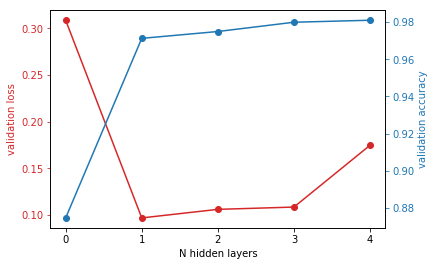

In [14]:
ax1=plt.subplot(111)
ax1.plot(np.array(model_loss)[:,1], color="tab:red", marker="o")
ax1.tick_params('y', colors='tab:red')
ax1.set_ylabel(ylabel = "validation loss", color="tab:red")
ax1.set_xticks([0,1,2,3,4])
ax1.set_xlabel("N hidden layers")
ax2 = ax1.twinx()
ax2.plot(np.array(model_acc)[:,1], color="tab:blue", marker="o")
ax2.tick_params('y', colors='tab:blue')
ax2.set_ylabel(ylabel = "validation accuracy", color="tab:blue")
plt.show()

In [15]:
np.array(model_accs_per_class)[0,:,1]

array([0.98989296, 0.60379595, 0.98155862, 0.80285037, 0.99585062])

In [16]:
np.array(model_accs_per_class)

array([[[1.27692411e-01, 9.89892960e-01],
        [8.40866790e-01, 6.03795946e-01],
        [8.35208203e-02, 9.81558621e-01],
        [4.78747834e-01, 8.02850366e-01],
        [1.23558262e-02, 9.95850623e-01]],

       [[1.72157014e-01, 9.74435210e-01],
        [1.67435509e-01, 9.34756815e-01],
        [1.39265204e-02, 9.94051158e-01],
        [1.31007623e-01, 9.53087866e-01],
        [2.66615906e-04, 1.00000000e+00]],

       [[1.24193137e-01, 9.75624263e-01],
        [1.62965495e-01, 9.61447239e-01],
        [3.36869673e-02, 9.89886999e-01],
        [2.06862052e-01, 9.47743475e-01],
        [2.92908468e-03, 1.00000000e+00]],

       [[9.19410931e-02, 9.80975032e-01],
        [1.86307266e-01, 9.67378438e-01],
        [3.79440202e-02, 9.89886999e-01],
        [2.25222705e-01, 9.61401403e-01],
        [1.39153723e-03, 1.00000000e+00]],

       [[1.27913973e-01, 9.79785979e-01],
        [1.92394299e-01, 9.70937133e-01],
        [4.31546798e-02, 9.92861390e-01],
        [5.09359655e-01, 9

## Rotation Speed dependent evaluation

In [17]:
from tensorflow.keras.models import load_model
model0 = load_model(f"{model_path}/fft_fcn_0_layers.h5")
model1 = load_model(f"{model_path}/fft_fcn_1_layers.h5")
model2 = load_model(f"{model_path}/fft_fcn_2_layers.h5")
model3 = load_model(f"{model_path}/fft_fcn_3_layers.h5")
model4 = load_model(f"{model_path}/fft_fcn_4_layers.h5")

In [18]:
model2.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cam_layer (InputLayer)       [(None, 2048)]            0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 1025      
Total params: 3,148,801
Trainable params: 3,148,801
Non-trainable params: 0
_________________________________________________

In [19]:
accuracies_per_class = []
for i in range(5):
    filepath_i = f"{model_path}/fft_fcn_{i}_layers.h5"
    model_i = load_model(filepath_i)
    
    val_acc_1 = model_i.evaluate(X_val_fft_1, y_val_1)
    val_acc_2 = model_i.evaluate(X_val_fft_2, y_val_2)
    val_acc_3 = model_i.evaluate(X_val_fft_3, y_val_3)
    val_acc_4 = model_i.evaluate(X_val_fft_4, y_val_4)
    val_acc_5 = model_i.evaluate(X_val_fft_5, y_val_5)
    accuracies_per_class.append([val_acc_1, val_acc_2, val_acc_3, val_acc_4, val_acc_5])

1687/1687 [==============================] - 0s 185us/sample - loss: 0.0013 - accuracy: 1.0000


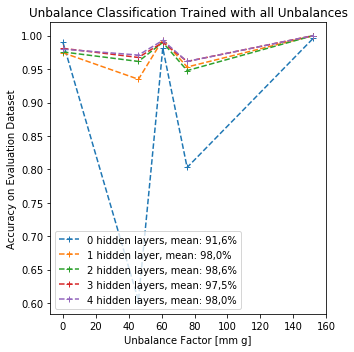

In [20]:
fig=plt.figure(figsize=(5,5))
ax1=plt.subplot(111, title = "Unbalance Classification Trained with all Unbalances")
unbalances = np.array([0, 4.59e-5, 6.07e-5,7.55e-5,1.521e-4])
ax1.plot(1e6*unbalances, np.array(accuracies_per_class)[0,:,1], label="0 hidden layers, mean: 91,6%", marker="+", ls="--")
ax1.plot(1e6*unbalances, np.array(accuracies_per_class)[1,:,1], label="1 hidden layer, mean: 98,0%", marker="+", ls="--")
ax1.plot(1e6*unbalances, np.array(accuracies_per_class)[2,:,1], label="2 hidden layers, mean: 98,6%", marker="+", ls="--")
ax1.plot(1e6*unbalances, np.array(accuracies_per_class)[3,:,1], label="3 hidden layers, mean: 97,5%", marker="+", ls="--")
ax1.plot(1e6*unbalances, np.array(accuracies_per_class)[4,:,1], label="4 hidden layers, mean: 98,0%", marker="+", ls="--")
plt.ylabel("Accuracy on Evaluation Dataset")
plt.xlabel("Unbalance Factor [mm g]")
plt.legend()
plt.tight_layout()
plt.show()

In [21]:
from scipy.stats import mode

def v2rpm(v):
    return 212*v + 209

fade_in = np.arange(0.0, 4.0, 4.0/(3*4096))
measurement_circle = np.repeat(np.arange(4.0, 8.2, 0.1), 4096*20.0)
# Messung: Anlaufen + 2 Spannungsdurchläufe
measurement = np.concatenate([fade_in, np.tile(measurement_circle,3)]) 
# Auswählen der Daten wie tatsächlich verwendet
measurement1 = measurement[50000:]
measurement1 = measurement1[:int(len(measurement1)/4096)*4096].reshape(-1,4096)
voltages_measurement = mode(measurement1, axis=1)[0]
voltages_used = np.concatenate([voltages_measurement[:len(X_val_fft_1)],
                                voltages_measurement[:len(X_val_fft_2)],
                                voltages_measurement[:len(X_val_fft_3)],
                                voltages_measurement[:len(X_val_fft_4)],
                                voltages_measurement[:len(X_val_fft_5)]])
rpms_used = v2rpm(voltages_used)

In [22]:
rpm_borders = np.arange(1050, 1975, 25)
errors_per_rpm_range0 = []
errors_per_rpm_range1 = []
errors_per_rpm_range2 = []
errors_per_rpm_range3 = []
errors_per_rpm_range4 = []
for i in range(len(rpm_borders)-1):
    eval_inds = np.where((rpms_used>rpm_borders[i])&(rpms_used<rpm_borders[i+1]))[0]
    errors_per_rpm_range0.append(
        1-np.mean(np.abs(np.int32(model0.predict(X_val_fft_sc[eval_inds])>0.5).reshape(-1)-y_val[eval_inds])))
    errors_per_rpm_range1.append(
        1-np.mean(np.abs(np.int32(model1.predict(X_val_fft_sc[eval_inds])>0.5).reshape(-1)-y_val[eval_inds])))
    errors_per_rpm_range2.append(
        1-np.mean(np.abs(np.int32(model2.predict(X_val_fft_sc[eval_inds])>0.5).reshape(-1)-y_val[eval_inds])))
    errors_per_rpm_range3.append(
        1-np.mean(np.abs(np.int32(model3.predict(X_val_fft_sc[eval_inds])>0.5).reshape(-1)-y_val[eval_inds])))
    errors_per_rpm_range4.append(
        1-np.mean(np.abs(np.int32(model4.predict(X_val_fft_sc[eval_inds])>0.5).reshape(-1)-y_val[eval_inds])))

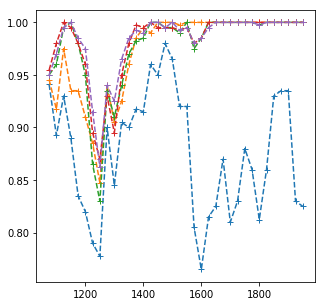

In [23]:
fig=plt.figure(figsize=(5,5))
plt.plot(np.array(rpm_borders[:-1])+25, errors_per_rpm_range0, marker="+", ls="--")
plt.plot(np.array(rpm_borders[:-1])+25, errors_per_rpm_range1, marker="+", ls="--")
plt.plot(np.array(rpm_borders[:-1])+25, errors_per_rpm_range2, marker="+", ls="--")
plt.plot(np.array(rpm_borders[:-1])+25, errors_per_rpm_range3, marker="+", ls="--")
plt.plot(np.array(rpm_borders[:-1])+25, errors_per_rpm_range4, marker="+", ls="--")
plt.show()

## Pairwise Unbalance Training and Evaluation

In the next experiment, pairs of datasets are used. The number of hidden FC layers was again varied between 0 and 4.

In [24]:
X_dev = [X0, X1, X2, X3, X4]
y_dev = [y0, y1, y2, y3, y4]

X_val_separated = [X_val_fft_1, X_val_fft_2, X_val_fft_3, X_val_fft_4, X_val_fft_5]
y_val_separated = [y_val_1, y_val_2, y_val_3, y_val_4, y_val_5]

In [25]:
for layer_n in range(5):
    for dataset_i in range(4):
        X_dev_i = np.concatenate([X_dev[0], X_dev[dataset_i+1]])
        y_dev_i = np.concatenate([y_dev[0], y_dev[dataset_i+1]])
        X_val_i = np.concatenate([X_val_separated[0], X_val_separated[dataset_i+1]])
        y_val_i = np.concatenate([y_val_separated[0], y_val_separated[dataset_i+1]])

        train_test_ratio = 0.9
        X_train_i, X_test_i, y_train_i, y_test_i = train_test_split(
            X_dev_i,y_dev_i, test_size = 1-train_test_ratio, random_state = 0)

        X_train_fft_i = np.abs(np.fft.rfft(X_train_i, axis=1))[:,:int(window/2)]
        X_test_fft_i = np.abs(np.fft.rfft(X_test_i, axis=1))[:,:int(window/2)]
        X_train_fft_i[:,0]=0
        X_test_fft_i[:,0]=0

        scaler = RobustScaler(quantile_range=(5,95)).fit(X_train_fft_i)
        X_train_fft_sc_i = scaler.transform(X_train_fft_i)
        X_test_fft_sc_i = scaler.transform(X_test_fft_i)

        if not use_reference_models:
            weight_for_0 = len(y_dev_i)/(2*len(y_dev_i[y_dev_i==0]))
            weight_for_1 = len(y_dev_i)/(2*len(y_dev_i[y_dev_i==1]))
            class_weight = {0: weight_for_0, 1: weight_for_1}

            X_in = Input(shape=(X_train_fft_i.shape[1],), name="cam_layer")
            previous_layer = X_in
            for j in range(layer_n):
                x = Dense(units = 1024, activation="linear")(previous_layer)
                x = LeakyReLU(alpha=0.05)(x)
                previous_layer = x
            X_out = Dense(units = 1, activation = 'sigmoid')(previous_layer)
            model_i = Model(X_in, X_out)

            best_model_filepath = f"{model_path}_fft_fcn_{layer_n}_layers_dataset_pair_{dataset_i}.h5"
            checkpoint = ModelCheckpoint(best_model_filepath, monitor='val_loss', 
                                         verbose=1, save_best_only=True, mode='min')
            model_i.compile(optimizer = Adam(lr=0.0005), loss = 'binary_crossentropy', 
                            metrics = ['accuracy'])
            model_i.summary()

            model_i.fit(X_train_fft_sc_i, y_train_i, epochs = 100, batch_size = 128,
                       validation_data=(X_test_fft_sc_i, y_test_i), callbacks=[checkpoint], 
                        class_weight=class_weight)
            

In [26]:
for layer_n in range(5):
    for dataset_i in range(4):        
        best_model_filepath = f"{model_path}/fft_fcn_{layer_n}_layers_dataset_pair_{dataset_i}.h5"
        model_i = load_model(best_model_filepath)
        train_acc = model_i.evaluate(X_train_fft_sc_i, y_train_i)
        val_acc = model_i.evaluate(X_val_i, y_val_i)
        print(f"Layers: {layer_n}, dataset pair {dataset_i}")
        print(train_acc)
        print(val_acc)
        

3369/3369 [==============================] - 0s 26us/sample - loss: 0.2581 - accuracy: 0.9534
Layers: 0, dataset pair 0
[0.5771139479057478, 0.86985004]
[0.2581437199080077, 0.95339864]
3369/3369 [==============================] - 0s 30us/sample - loss: 6.4344 - accuracy: 0.5025
Layers: 0, dataset pair 1
[0.8062112429618342, 0.7671091]
[6.434418417270105, 0.502523]
3369/3369 [==============================] - 0s 34us/sample - loss: 0.4021 - accuracy: 0.9240
Layers: 0, dataset pair 2
[0.16780451773168958, 0.9391484]
[0.4020850309013898, 0.9240131]
3369/3369 [==============================] - 0s 32us/sample - loss: 0.2299 - accuracy: 0.9944
Layers: 0, dataset pair 3
[0.08777843299374008, 0.99422514]
[0.22985087401070567, 0.9943603]
3369/3369 [==============================] - 0s 108us/sample - loss: 0.6793 - accuracy: 0.8738
Layers: 1, dataset pair 0
[0.6676361259150723, 0.7913291]
[0.6793096680871025, 0.8738498]
3369/3369 [==============================] - 0s 126us/sample - loss: 5.1516

In [27]:
accuracies = []
for layer_n in range(5):
    accuracies_layer_i = []
    for dataset_i in range(4):
        X_val_i = np.concatenate([X_val_separated[0], X_val_separated[dataset_i+1]])
        y_val_i = np.concatenate([y_val_separated[0], y_val_separated[dataset_i+1]])
        
        filepath = f"{model_path}/fft_fcn_{layer_n}_layers_dataset_pair_{dataset_i}.h5"
        model_i = load_model(filepath)
        accuracies_layer_i.append(model_i.evaluate(X_val_i, y_val_i)[1])
    accuracies.append(accuracies_layer_i)
accuracies = np.array(accuracies)

3369/3369 [==============================] - 1s 219us/sample - loss: 0.0394 - accuracy: 0.9902


In [28]:
np.mean(accuracies, axis=1)

array([0.8634335 , 0.8729507 , 0.85965824, 0.91296524, 0.8845303 ],
      dtype=float32)

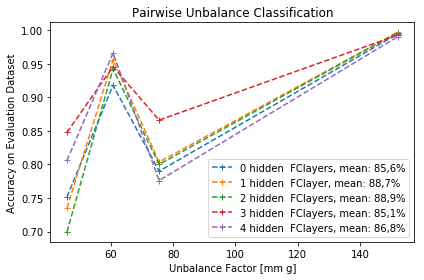

In [29]:
fig=plt.figure()
ax1=plt.subplot(111, title = "Pairwise Unbalance Classification")
unbalances = np.array([0, 4.59e-5, 6.07e-5,7.55e-5,1.521e-4])
ax1.plot(1e6*unbalances[1:], accuracies[0,:], label="0 hidden  FClayers, mean: 85,6%", marker="+", ls="--")
ax1.plot(1e6*unbalances[1:], accuracies[1,:], label="1 hidden  FClayer, mean: 88,7%", marker="+", ls="--")
ax1.plot(1e6*unbalances[1:], accuracies[2,:], label="2 hidden  FClayers, mean: 88,9%", marker="+", ls="--")
ax1.plot(1e6*unbalances[1:], accuracies[3,:], label="3 hidden  FClayers, mean: 85,1%", marker="+", ls="--")
ax1.plot(1e6*unbalances[1:], accuracies[4,:], label="4 hidden  FClayers, mean: 86,8%", marker="+", ls="--")
plt.ylabel("Accuracy on Evaluation Dataset")
plt.xlabel("Unbalance Factor [mm g]")
plt.legend()
plt.tight_layout()
plt.show()

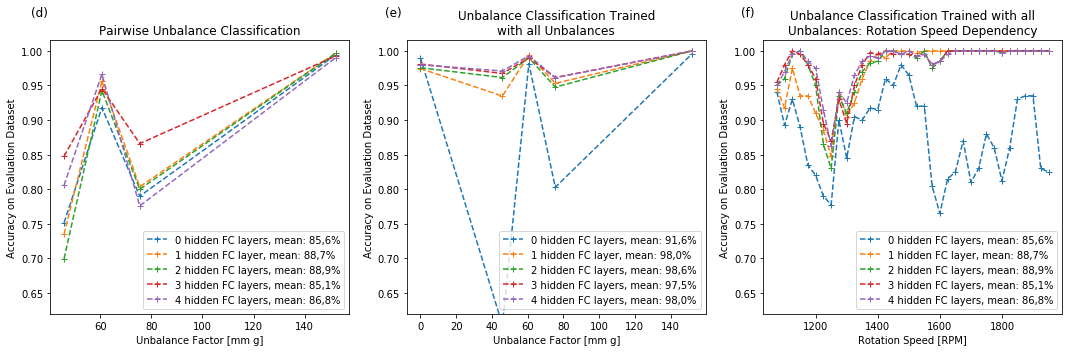

In [30]:
fig=plt.figure(figsize=(15,5))
ax1=plt.subplot(132, title = "Unbalance Classification Trained\nwith all Unbalances")
unbalances = np.array([0, 4.59e-5, 6.07e-5,7.55e-5,1.521e-4])
ax1.plot(1e6*unbalances, np.array(accuracies_per_class)[0,:,1], 
         label="0 hidden FC layers, mean: 91,6%", marker="+", ls="--")
ax1.plot(1e6*unbalances, np.array(accuracies_per_class)[1,:,1], 
         label="1 hidden FC layer, mean: 98,0%", marker="+", ls="--")
ax1.plot(1e6*unbalances, np.array(accuracies_per_class)[2,:,1], 
         label="2 hidden FC layers, mean: 98,6%", marker="+", ls="--")
ax1.plot(1e6*unbalances, np.array(accuracies_per_class)[3,:,1], 
         label="3 hidden FC layers, mean: 97,5%", marker="+", ls="--")
ax1.plot(1e6*unbalances, np.array(accuracies_per_class)[4,:,1], 
         label="4 hidden FC layers, mean: 98,0%", marker="+", ls="--")
plt.ylabel("Accuracy on Evaluation Dataset")
plt.xlabel("Unbalance Factor [mm g]")
plt.ylim([0.62, 1.015])
plt.legend(loc="lower right")
ax1.text(-20, 1.05,"(e)", fontsize=12)
ax2=plt.subplot(131, title = "Pairwise Unbalance Classification")
ax2.plot(1e6*unbalances[1:], accuracies[0,:], 
         label="0 hidden FC layers, mean: 85,6%", marker="+", ls="--")
ax2.plot(1e6*unbalances[1:], accuracies[1,:], 
         label="1 hidden FC layer, mean: 88,7%", marker="+", ls="--")
ax2.plot(1e6*unbalances[1:], accuracies[2,:], 
         label="2 hidden FC layers, mean: 88,9%", marker="+", ls="--")
ax2.plot(1e6*unbalances[1:], accuracies[3,:], 
         label="3 hidden FC layers, mean: 85,1%", marker="+", ls="--")
ax2.plot(1e6*unbalances[1:], accuracies[4,:], 
         label="4 hidden FC layers, mean: 86,8%", marker="+", ls="--")
plt.ylabel("Accuracy on Evaluation Dataset")
plt.xlabel("Unbalance Factor [mm g]")
plt.ylim([0.62, 1.015])
plt.legend()
ax2.text(33, 1.05,"(d)", fontsize=12)
title = "Unbalance Classification Trained with all\nUnbalances: Rotation Speed Dependency"
ax3 = plt.subplot(133, title=title)
ax3.plot(np.array(rpm_borders[:-1])+25, errors_per_rpm_range0, 
         marker="+", ls="--", label="0 hidden FC layers, mean: 85,6%")
ax3.plot(np.array(rpm_borders[:-1])+25, errors_per_rpm_range1, 
         marker="+", ls="--", label="1 hidden FC layer, mean: 88,7%")
ax3.plot(np.array(rpm_borders[:-1])+25, errors_per_rpm_range2, 
         marker="+", ls="--", label="2 hidden FC layers, mean: 88,9%")
ax3.plot(np.array(rpm_borders[:-1])+25, errors_per_rpm_range3, 
         marker="+", ls="--", label="3 hidden FC layers, mean: 85,1%")
ax3.plot(np.array(rpm_borders[:-1])+25, errors_per_rpm_range4, 
         marker="+", ls="--", label="4 hidden FC layers, mean: 86,8%")
plt.ylabel("Accuracy on Evaluation Dataset")
plt.xlabel("Rotation Speed [RPM]")
plt.ylim([0.62, 1.015])
plt.legend(loc="lower right")
ax3.text(960, 1.05,"(f)", fontsize=12)
plt.tight_layout()
plt.show()